# Import Libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats




# Import Dataset

In [6]:
raw_SPY_intraday_df = pd.read_csv("../Data/SPY_intraday_polygon_2024_2025.csv")

# Data Cleaning

In [7]:
raw_SPY_intraday_df.head()

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN


In [8]:
# Create copy of raw dataframe
SPY_intraday_df = raw_SPY_intraday_df.copy()
SPY_intraday_df['timestamp_utc'] = pd.to_datetime(SPY_intraday_df['timestamp_utc'], utc=True)
SPY_intraday_df['timestamp_ny'] = SPY_intraday_df['timestamp_utc'].dt.tz_convert('America/New_York')

mask_rth = (
    (SPY_intraday_df['timestamp_ny'].dt.dayofweek < 5) &
    (SPY_intraday_df['timestamp_ny'].dt.time >= pd.to_datetime('9:30').time()) &
    (SPY_intraday_df['timestamp_ny'].dt.time <= pd.to_datetime('16:00').time())
)
rth = SPY_intraday_df.loc[mask_rth, ['timestamp_utc', 'timestamp_ny', 'open', 'high', 'low', 'close', 'volume']].sort_values('timestamp_ny')

# reindex wihtin each trading day ONLY (prevents ffill across nights/weekends)
def _reindex_day(g):
    idx = pd.date_range(g['timestamp_ny'].min().floor('min'),
                        g['timestamp_ny'].max().floor('min'),
                        freq='1min', tz='America/New_York')
    out = g.set_index('timestamp_ny').reindex(idx)
    out[['open','high','low','close','volume']] = out[['open','high','low','close','volume']].ffill()
    out['timestamp_ny']  = out.index
    out['timestamp_utc'] = out['timestamp_ny'].dt.tz_convert('UTC')
    return out.reset_index(drop=True)

rth['session_date'] = rth['timestamp_ny'].dt.date
# Group by calendar day derived from timestamp_ny
rth = (
    rth.groupby(rth['timestamp_ny'].dt.date, group_keys=False)
       .apply(_reindex_day)
       .reset_index(drop=True)
)

rth = rth.drop(columns=['session_date'], errors='ignore')

## Check data types

In [9]:
SPY_intraday_df.dtypes

timestamp_utc                 datetime64[ns, UTC]
open                                      float64
high                                      float64
low                                       float64
close                                     float64
volume                                    float64
vwap                                      float64
ret                                       float64
vol_5m                                    float64
vol_30m                                   float64
timestamp_ny     datetime64[ns, America/New_York]
dtype: object

## Check for missing values

In [10]:
SPY_intraday_df.isna().sum()


timestamp_utc     0
open              0
high              0
low               0
close             0
volume            0
vwap              0
ret               1
vol_5m            5
vol_30m          30
timestamp_ny      0
dtype: int64

In [11]:
SPY_intraday_df[SPY_intraday_df.isna().any(axis=1)]

,timestamp_utc,open,high,low,close,volume,vwap,ret,vol_5m,vol_30m,timestamp_ny
0,2024-01-02 09:00:00+00:00,476.25,476.36,476.00,476.31,20460.0,476.2997,NaN,NaN,NaN,2024-01-02 04:00:00-05:00
1,2024-01-02 09:01:00+00:00,476.34,476.34,476.29,476.29,6369.0,476.3201,-0.000042,NaN,NaN,2024-01-02 04:01:00-05:00
2,2024-01-02 09:02:00+00:00,476.29,476.29,476.28,476.28,6152.0,476.2802,-0.000021,NaN,NaN,2024-01-02 04:02:00-05:00
3,2024-01-02 09:03:00+00:00,476.27,476.27,476.27,476.27,369.0,476.2701,-0.000021,NaN,NaN,2024-01-02 04:03:00-05:00
4,2024-01-02 09:05:00+00:00,476.20,476.20,476.19,476.20,547.0,476.1955,-0.000147,NaN,NaN,2024-01-02 04:05:00-05:00
5,2024-01-02 09:06:00+00:00,476.18,476.18,476.18,476.18,230.0,476.1778,-0.000042,0.000053,NaN,2024-01-02 04:06:00-05:00
6,2024-01-02 09:07:00+00:00,476.21,476.21,476.14,476.14,5624.0,476.1469,-0.000084,0.000054,NaN,2024-01-02 04:07:00-05:00
7,2024-01-02 09:08:00+00:00,476.19,476.19,476.19,476.19,107.0,476.1895,0.000105,0.000093,NaN,2024-01-02 04:08:00-05:00
8,2024-01-02 09:10:00+00:00,476.13,476.13,476.12,476.12,340.0,476.1294,-0.000147,0.000104,NaN,2024-01-02 04:10:00-05:00
9,2024-01-02 09:11:00+00:00,476.03,476.03,476.02,476.03,341.0,476.0236,-0.000189,0.000114,NaN,2024-01-02 04:11:00-05:00


Missing values are the first 45mins in the range of the price history as the window of time has not been formed yet to calculate the 5m and 30m rolling volatility and also return. Dont know why its missing from 9:30-9:45, but will be dropped anyways probably when filtering for the date range.

# Basic OHLC sanity checks (flag)

In [12]:
bad_ohlc = rth[
    (rth['high'] < rth[['open','close']].max(axis=1)) |
    (rth['low']  > rth[['open','close']].min(axis=1)) |
    (rth['low']  > rth['high'])
]
print("Bad OHLC rows:", len(bad_ohlc))


Bad OHLC rows: 0


# Compute features after RTH/sessionization

In [13]:
rth = rth.sort_values('timestamp_ny')
rth['ret']     = rth['close'].pct_change()
rth['vol_5m']  = rth['ret'].rolling(5,  min_periods=5).std()
rth['vol_30m'] = rth['ret'].rolling(30, min_periods=30).std()

clean = rth.dropna(subset=['ret','vol_5m','vol_30m']).copy()

# Day Completeness (390 bars / day)

In [14]:
bars_per_day = clean.assign(day=clean['timestamp_ny'].dt.date).groupby('day')['timestamp_ny'].count()
incomplete = bars_per_day[bars_per_day != 390]
print("Days != 390 bars:", len(incomplete))

Days != 390 bars: 454


# Outliers & Gaps (keep the data, just label)

In [15]:
ret_z = (clean['ret'] - clean['ret'].mean()) / clean['ret'].std(ddof=0)
clean['is_outlier_z5'] = ret_z.abs() > 5

# Optional winsorized copy for visuals only
qlo, qhi = clean['ret'].quantile([0.001, 0.999])
eda = clean.assign(ret_wins = clean['ret'].clip(qlo, qhi))

## Check for consistent frequency

In [ ]:
# diffs = SPY_intraday_df['timestamp_utc'].diff().value_counts().sort_index()
# print(diffs.head(10))


timestamp_utc
0 days 00:01:00    330643
0 days 00:02:00     19489
0 days 00:03:00      7235
0 days 00:04:00      3229
0 days 00:05:00      1685
0 days 00:06:00       957
0 days 00:07:00       583
0 days 00:08:00       388
0 days 00:09:00       243
0 days 00:10:00       146
Name: count, dtype: int64


- The time interval analysis shows that most data points (`≈330,000 rows`) are spaced exactly **1 minute apart**, indicating generally consistent intraday sampling.
- However, there are a significant number of longer gaps:
  - `~19,000` rows have **2-minute gaps**
  - Smaller counts for gaps of **3–10 minutes**, progressively fewer as the gap increases.
- This suggests that the dataset is **not perfectly minute-consistent**, and there are periods where 1 or more minutes of data are missing.
- Such gaps are typical in **intraday financial data** due to:
  - Non-trading periods (overnight, weekends)
  - Low activity or missing ticks in pre/post-market hours
  - Occasional missing bars from the data provider
- Before performing time-based calculations (e.g., rolling volatility or model training), it may be necessary to **reindex to a complete 1-minute frequency** and **forward-fill** missing values to ensure even time steps.


### Forward-fill index

In [45]:
# SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# # Create full 1-minute date range
# full_index = pd.date_range(
#     start=SPY_intraday_df.index.min(),
#     end=SPY_intraday_df.index.max(),
#     freq='1min'
# )

# # Reindex and forward-fill
# SPY_intraday_df = SPY_intraday_df.reindex(full_index)
# SPY_intraday_df.ffill(inplace=True)

# # Reset index and rename
# SPY_intraday_df.reset_index(inplace=True)
# SPY_intraday_df.rename(columns={'index': 'timestamp_utc'}, inplace=True)

# # Verify
print(SPY_intraday_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365406 entries, 0 to 365405
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype                           
---  ------         --------------   -----                           
 0   timestamp_utc  365406 non-null  datetime64[ns, UTC]             
 1   open           365406 non-null  float64                         
 2   high           365406 non-null  float64                         
 3   low            365406 non-null  float64                         
 4   close          365406 non-null  float64                         
 5   volume         365406 non-null  float64                         
 6   vwap           365406 non-null  float64                         
 7   ret            365405 non-null  float64                         
 8   vol_5m         365401 non-null  float64                         
 9   vol_30m        365376 non-null  float64                         
 10  timestamp_ny   365406 non-null  datetime64[n

## Validate Trading Hours

Do i need to do this?
- this part is wrong because it's not always 14:30 UTC to 21:00 UTC due to daylight saving changes
- I've readjusted the timezone to ny time above

In [ ]:
# # Filter regular U.S. trading hours only (14:30–21:00 UTC, weekdays)
# SPY_intraday_df = SPY_intraday_df[
#     (SPY_intraday_df['timestamp_utc'].dt.time >= pd.to_datetime("14:30").time()) &
#     (SPY_intraday_df['timestamp_utc'].dt.time <= pd.to_datetime("21:00").time()) &
#     (SPY_intraday_df['timestamp_utc'].dt.dayofweek < 5)
# ]

## Check for outliers

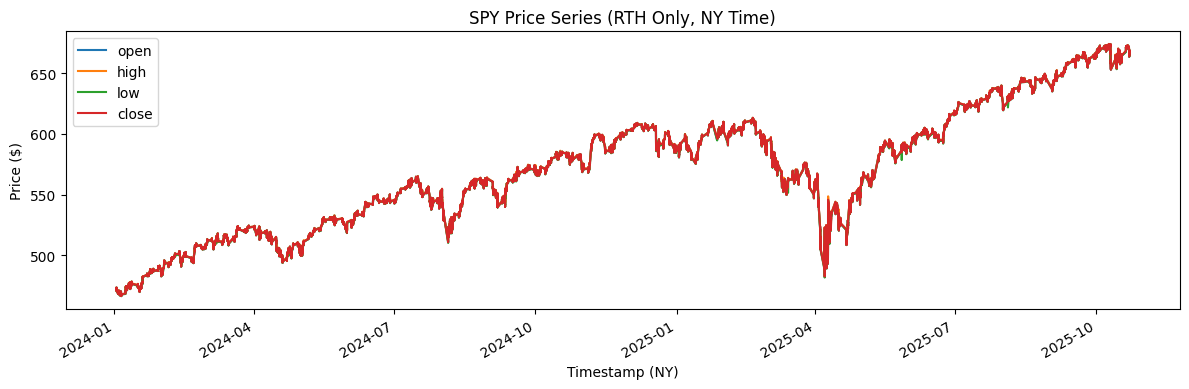

In [16]:
# SPY_intraday_df[['open','high','low','close']].plot(figsize=(12,4), title='SPY Price Series')
# plt.show()

# Use the cleaned RTH dataset
fig, ax = plt.subplots(figsize=(12, 4))
clean.plot(x="timestamp_ny", y=["open","high","low","close"], ax=ax)
ax.set_title("SPY Price Series (RTH Only, NY Time)")
ax.set_xlabel("Timestamp (NY)")
ax.set_ylabel("Price ($)")
plt.tight_layout()
plt.show()



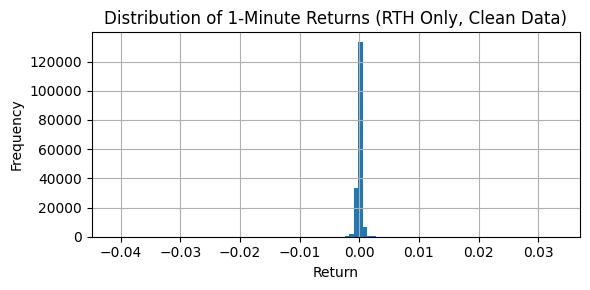

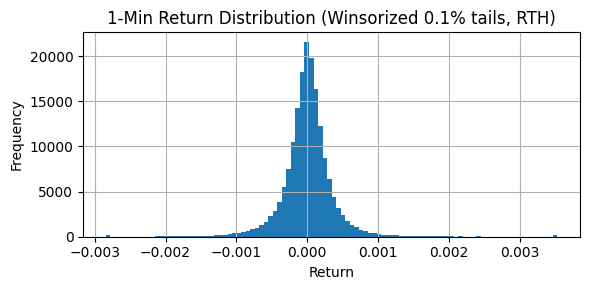

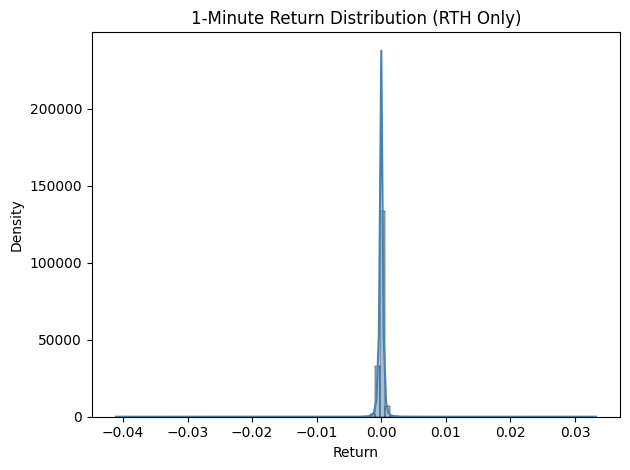

In [17]:
# SPY_intraday_df['ret'].hist(bins=100, figsize=(6,3))
# plt.title("Distribution of 1-Minute Returns")
# plt.show()
clean['ret'].hist(bins=100, figsize=(6,3))
plt.title("Distribution of 1-Minute Returns (RTH Only, Clean Data)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

qlo, qhi = clean['ret'].quantile([0.001, 0.999])
clean['ret'].clip(qlo, qhi).hist(bins=100, figsize=(6,3))
plt.title("1-Min Return Distribution (Winsorized 0.1% tails, RTH)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

sns.histplot(clean['ret'], bins=100, kde=True, color='steelblue')
plt.title("1-Minute Return Distribution (RTH Only)")
plt.xlabel("Return")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [18]:
# z_scores = np.abs((SPY_intraday_df['ret'] - SPY_intraday_df['ret'].mean()) / SPY_intraday_df['ret'].std())
# outliers = SPY_intraday_df[z_scores > 5]  # 5 std deviations away
# print(f"Outliers detected: {len(outliers)}")
# outliers.head()
# Compute z-scores on the cleaned dataset

z_scores = np.abs((clean['ret'] - clean['ret'].mean()) / clean['ret'].std(ddof=0))
outliers = clean[z_scores > 5]  # 5 standard deviations away

print(f"Outliers detected (|z|>5): {len(outliers)}")
display(outliers.head())


Outliers detected (|z|>5): 508


,timestamp_utc,open,high,low,close,volume,timestamp_ny,ret,vol_5m,vol_30m,is_outlier_z5
391,2024-01-03 14:30:00+00:00,470.43,470.53,470.19,470.48,876080.0,2024-01-03 09:30:00-05:00,-0.004402,0.002057,0.000870,True
1955,2024-01-09 14:30:00+00:00,471.87,472.08,471.86,471.87,611136.0,2024-01-09 09:30:00-05:00,-0.005417,0.002406,0.001063,True
3128,2024-01-12 14:30:00+00:00,477.84,478.01,477.73,477.94,711811.0,2024-01-12 09:30:00-05:00,0.003570,0.001639,0.000717,True
3910,2024-01-17 14:30:00+00:00,471.82,471.94,471.71,471.73,768460.0,2024-01-17 09:30:00-05:00,-0.006926,0.003194,0.001294,True
4301,2024-01-18 14:30:00+00:00,474.01,474.22,473.95,474.06,704237.0,2024-01-18 09:30:00-05:00,0.003811,0.001770,0.000749,True


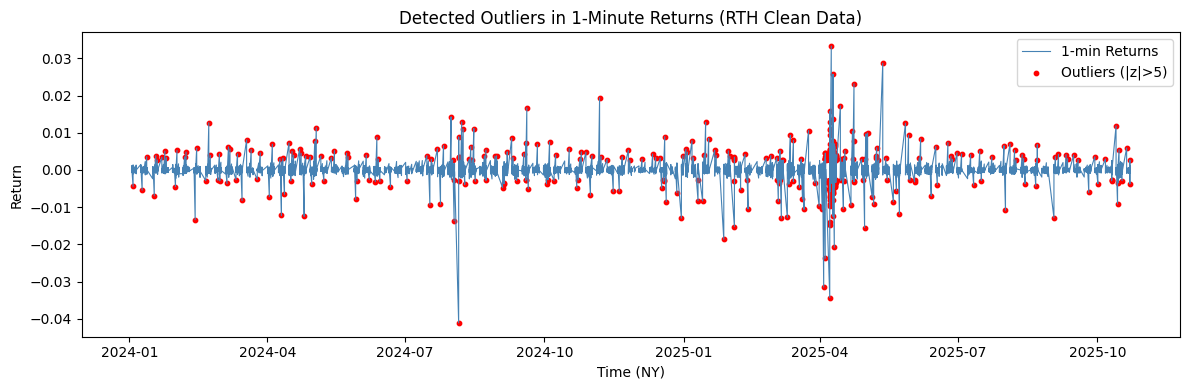

In [19]:
# plt.figure(figsize=(12,4))
# plt.plot(SPY_intraday_df['timestamp_utc'], SPY_intraday_df['ret'], label='Returns')
# plt.scatter(outliers['timestamp_utc'], outliers['ret'], color='red', label='Outliers')
# plt.title('Detected Outliers in 1-Minute Returns')
# plt.legend()
# plt.show()


plt.figure(figsize=(12,4))
plt.plot(clean['timestamp_ny'], clean['ret'], label='1-min Returns', color='steelblue', lw=0.8)
plt.scatter(outliers['timestamp_ny'], outliers['ret'], color='red', s=10, label='Outliers (|z|>5)')
plt.title('Detected Outliers in 1-Minute Returns (RTH Clean Data)')
plt.xlabel('Time (NY)')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()

# Compare Cleaned Dataset vs Old Dataset

In [20]:
# # Compare before vs. after
# print("Original rows:", len(raw_SPY_intraday_df))
# print("Cleaned rows:", len(SPY_intraday_df))
# print("Added rows (filled):", len(SPY_intraday_df) - len(raw_SPY_intraday_df))

# print("\nOriginal range:", raw_SPY_intraday_df['timestamp_utc'].min(), "→", raw_SPY_intraday_df['timestamp_utc'].max())
# print("New range:", SPY_intraday_df['timestamp_utc'].min(), "→", SPY_intraday_df['timestamp_utc'].max())

# Compare before vs after cleaning/reindexing (session-based, not global)
print("Original rows (raw Polygon data):", len(raw_SPY_intraday_df))
print("Cleaned rows (RTH only, per-session reindex):", len(clean))

# Optional: estimate how many bars were legitimately filled within sessions
added_rows = len(clean) - len(raw_SPY_intraday_df)
print("Approximate intra-session filled bars:", added_rows)

print("\nOriginal time range (raw):",
      raw_SPY_intraday_df['timestamp_utc'].min(), "→",
      raw_SPY_intraday_df['timestamp_utc'].max())

print("Cleaned time range (RTH):",
      clean['timestamp_utc'].min(), "→",
      clean['timestamp_utc'].max())

bars_per_day = (
    rth.assign(day = rth['timestamp_ny'].dt.date)
       .groupby('day')['timestamp_ny']
       .count()
)

print("\n Mean bars per day:", bars_per_day.mean())
print(bars_per_day.describe())
print("\nSample of shortest/longest days:")
display(bars_per_day.sort_values().head(10))
display(bars_per_day.sort_values(ascending=False).head(10))


Original rows (raw Polygon data): 365406
Cleaned rows (RTH only, per-session reindex): 177124
Approximate intra-session filled bars: -188282

Original time range (raw): 2024-01-02 09:00:00+00:00 → 2025-10-22 23:59:00+00:00
Cleaned time range (RTH): 2024-01-02 15:00:00+00:00 → 2025-10-22 20:00:00+00:00

 Mean bars per day: 390.20704845814976
count    454.000000
mean     390.207048
std       11.933826
min      211.000000
25%      391.000000
50%      391.000000
75%      391.000000
max      391.000000
Name: timestamp_ny, dtype: float64

Sample of shortest/longest days:


day
2024-12-24    211
2025-07-03    211
2024-01-02    391
2025-03-27    391
2025-03-26    391
2025-03-25    391
2025-03-24    391
2025-03-21    391
2025-03-20    391
2025-03-19    391
Name: timestamp_ny, dtype: int64

day
2024-01-02    391
2025-02-20    391
2025-03-28    391
2025-03-27    391
2025-03-26    391
2025-03-25    391
2025-03-24    391
2025-03-21    391
2025-03-20    391
2025-03-19    391
Name: timestamp_ny, dtype: int64

# Export Cleaned Dataset


In [21]:
SPY_intraday_df.to_csv("SPY_intraday_cleaned.csv", index=False)

# Exploratory Data Analysis

## Price History


### Close Price History

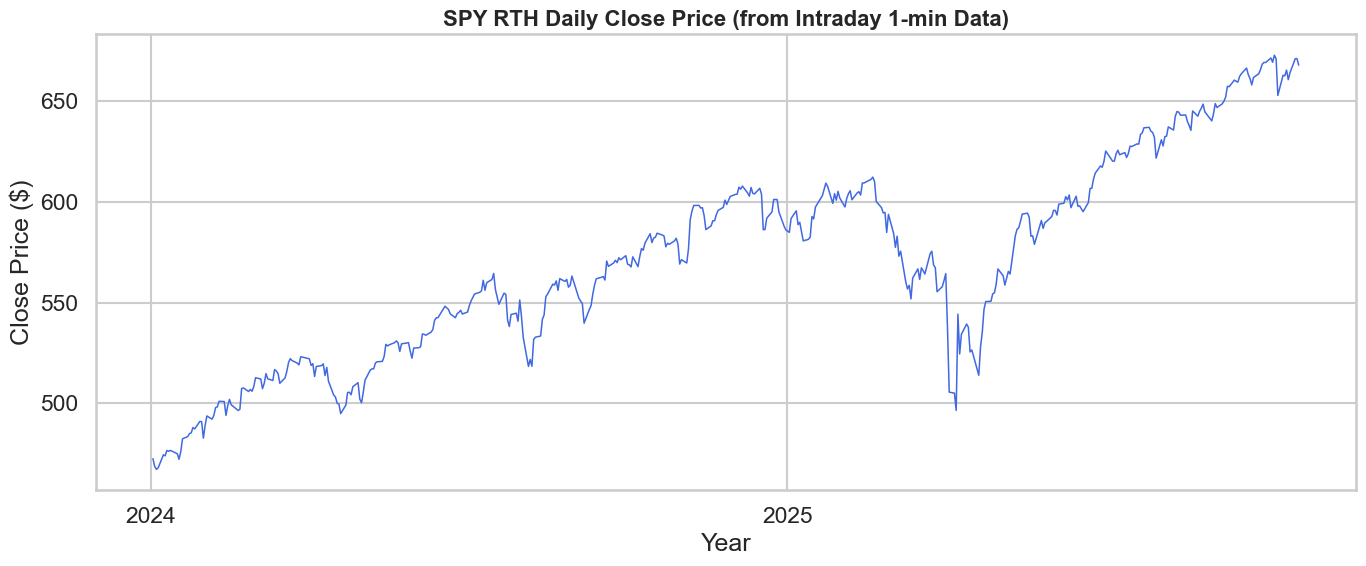

In [22]:
# # Set timestamp as index
# SPY_intraday_df = SPY_intraday_df.set_index('timestamp_utc')

# # Downsample to daily frequency (take last close per day)
# SPY_daily = SPY_intraday_df['close'].resample('1D').last().dropna()

# # Plot daily close price
# sns.set(style="whitegrid", context="talk")

# plt.figure(figsize=(14, 6))
# sns.lineplot(x=SPY_daily.index, y=SPY_daily.values, color='royalblue', linewidth=1.1)

# # Format x-axis
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.xticks(rotation=0)

# # Titles and labels
# plt.title("SPY Intraday Price History (Daily Close)", fontsize=16, weight='bold')
# plt.xlabel("Year")
# plt.ylabel("Close Price ($)")
# plt.tight_layout()
# plt.show()

# Use the cleaned RTH dataset in NY time
df_daily = (
    clean.set_index("timestamp_ny")
         .sort_index()
         .resample("1D")                # resample by calendar day (NY time)
         .agg(close=("close","last"))   # last RTH close each day
         .dropna()
)

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))
sns.lineplot(x=df_daily.index, y=df_daily["close"], color="royalblue", linewidth=1.1)

# Format x-axis for years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)

plt.title("SPY RTH Daily Close Price (from Intraday 1-min Data)", fontsize=16, weight="bold")
plt.xlabel("Year")
plt.ylabel("Close Price ($)")
plt.tight_layout()
plt.show()

## Regime analysis

### PCA and K-means Regime

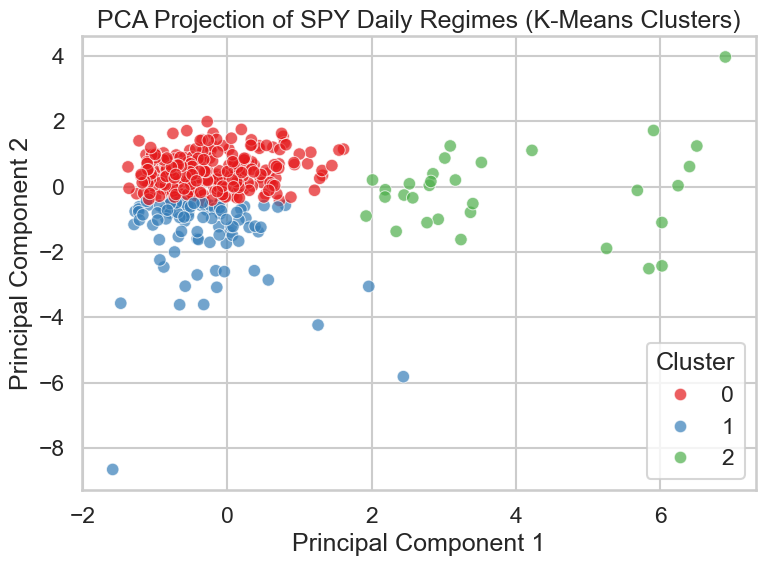

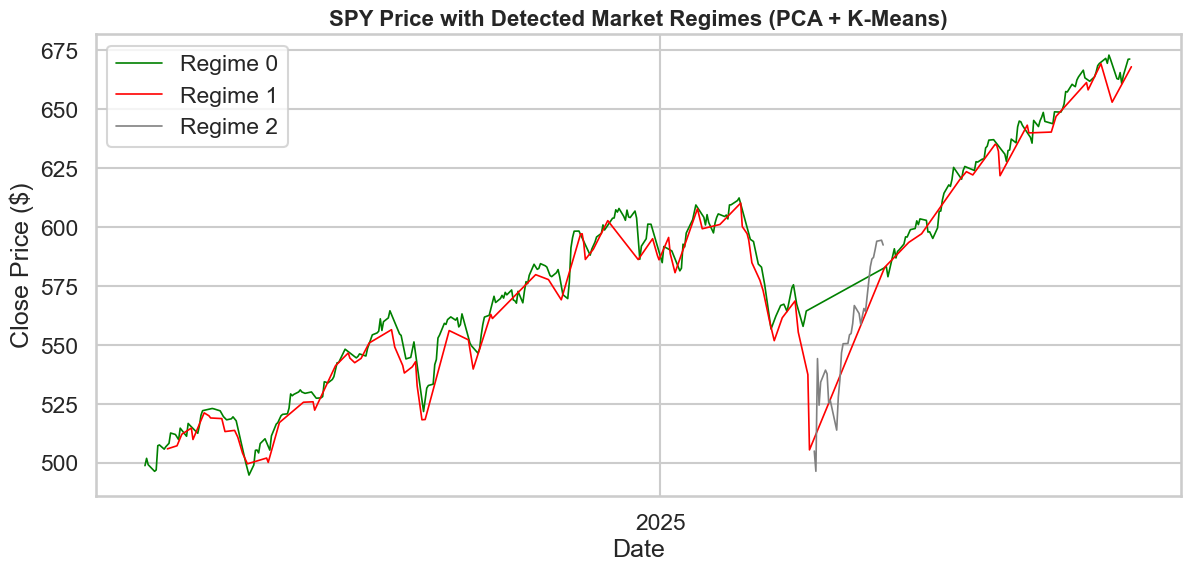

In [23]:
sns.set(style="whitegrid", context="talk")

#  build daily bars from CLEAN RTH data (NY TIME)
df_eda = clean.set_index("timestamp_ny").sort_index()



# Create daily close + volume bars ---
SPY_daily = (
    df_eda
    .resample('1D')
    .agg({'close':'last', 'volume':'sum'})
    .dropna()
)

# Feature Engineering ---
SPY_daily['log_return'] = np.log(SPY_daily['close'] / SPY_daily['close'].shift(1))
SPY_daily['volatility_10'] = SPY_daily['log_return'].rolling(10).std()
SPY_daily['volatility_30'] = SPY_daily['log_return'].rolling(30).std()
SPY_daily['volume_change'] = SPY_daily['volume'].pct_change()
SPY_daily['autocorr_5'] = SPY_daily['log_return'].rolling(5).apply(lambda x: x.autocorr(), raw=False)

# Clean + Prepare Feature Matrix ---
SPY_features = SPY_daily[['log_return', 'volatility_10', 'volatility_30', 'volume_change', 'autocorr_5']]
SPY_features = SPY_features.replace([np.inf, -np.inf], np.nan).dropna()

# Standardization + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(SPY_features)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

SPY_features = SPY_features.copy()
SPY_features["cluster"] = clusters

# Merge clusters back to daily data
SPY_daily = SPY_daily.join(SPY_features["cluster"], how="left")


# PCA visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=SPY_features['cluster'], palette='Set1', alpha=0.7)
plt.title("PCA Projection of SPY Daily Regimes (K-Means Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Time-series regime visualization
colors = {0:'green', 1:'red', 2:'gray'}
plt.figure(figsize=(14,6))
for cluster, color in colors.items():
    mask = SPY_daily['cluster'] == cluster
    plt.plot(SPY_daily.index[mask], SPY_daily['close'][mask], color=color, label=f'Regime {cluster}', linewidth=1.2)

plt.title("SPY Price with Detected Market Regimes (PCA + K-Means)", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [24]:
# Summarise Regime Characteristics
regime_summary = (
    SPY_daily
    .groupby('cluster')
    .agg(
        mean_return=('log_return', 'mean'),
        vol_10=('volatility_10', 'mean'),
        vol_30=('volatility_30', 'mean'),
        mean_volume_change=('volume_change', 'mean'),
        n_days=('close', 'count')
    )
    .sort_values('mean_return', ascending=False)
)

print("=== Regime Summary ===")
display(regime_summary)


=== Regime Summary ===


,mean_return,vol_10,vol_30,mean_volume_change,n_days
cluster,,,,,
2.0,0.005114,0.022231,0.025483,0.009561,31
0.0,0.003328,0.007342,0.007761,-0.044379,300
1.0,-0.009197,0.008215,0.007859,0.463541,93


In [25]:
# annualised metrics for easier comparison
regime_summary["ann_return"] = regime_summary["mean_return"] * 252
regime_summary["ann_vol"] = regime_summary["vol_30"] * np.sqrt(252)
regime_summary["Sharpe"] = regime_summary["ann_return"] / regime_summary["ann_vol"]
display(regime_summary)

,mean_return,vol_10,vol_30,mean_volume_change,n_days,ann_return,ann_vol,Sharpe
cluster,,,,,,,,
2.0,0.005114,0.022231,0.025483,0.009561,31,1.288619,0.404523,3.185526
0.0,0.003328,0.007342,0.007761,-0.044379,300,0.838678,0.123207,6.807058
1.0,-0.009197,0.008215,0.007859,0.463541,93,-2.317631,0.124762,-18.576478


### Markov Regime Switching Model

In [26]:
# Compute daily log returns ---
if isinstance(SPY_daily, pd.DataFrame) and 'close' in SPY_daily:
    ret = np.log(SPY_daily['close'] / SPY_daily['close'].shift(1))
else:
    ret = np.log(SPY_daily / SPY_daily.shift(1))

ret = ret.dropna()
ret = pd.Series(ret.values, index=ret.index, name='log_ret')

# Fit Markov Regime-Switching Model
mod = sm.tsa.MarkovRegression(ret, k_regimes=2, trend='c', switching_variance=True)
res = mod.fit(em_iter=50, search_reps=20)
print(res.summary())

#  Extract regime parameters (means & variances)
means = [res.params[i] for i, n in enumerate(res.model.param_names) if 'const' in n]
variances = [res.params[i] for i, n in enumerate(res.model.param_names) if 'sigma2' in n]

# Identify which regime is high-vol (larger variance)
high_vol_state = int(np.argmax(variances))
low_vol_state = 1 - high_vol_state

print("\nEstimated Regime Statistics:")
print(f"Regime 0 → mean={means[0]:.6f}, var={variances[0]:.8f}")
print(f"Regime 1 → mean={means[1]:.6f}, var={variances[1]:.8f}")
print(f"\nHigh-volatility regime: {high_vol_state}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                  453
Model:               MarkovRegression   Log Likelihood                1523.604
Date:                Sat, 08 Nov 2025   AIC                          -3035.209
Time:                        22:39:59   BIC                          -3010.514
Sample:                             0   HQIC                         -3025.478
                                - 453                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.549      0.000       0.001       0.002
sigma2      4.308e-05   4.81e-06      8.966      0.0

/var/folders/hp/kfy3hmy15mn6824slvj7zgd40000gn/T/ipykernel_18534/2942224122.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = [res.params[i] for i, n in enumerate(res.model.param_names) if 'const' in n]
/var/folders/hp/kfy3hmy15mn6824slvj7zgd40000gn/T/ipykernel_18534/2942224122.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variances = [res.params[i] for i, n in enumerate(res.model.param_names) if 'sigma2' in n]


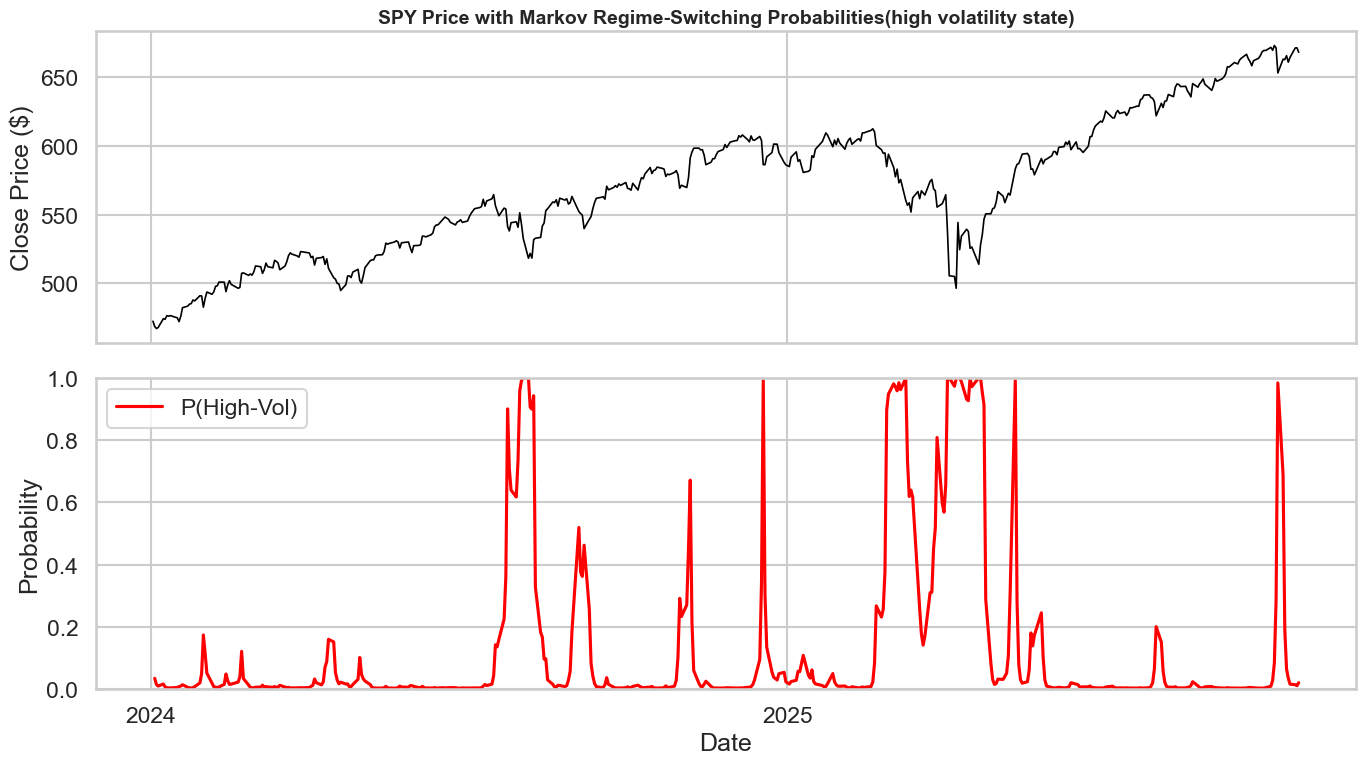

In [27]:
# Extract regime probabilities ---
probs = res.smoothed_marginal_probabilities
prob_highvol = probs[high_vol_state]

# align to SPY_daily index to avoid any index mismatches
p_hi = prob_highvol.reindex(SPY_daily.index).ffill()

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price (RTH daily close)
ax[0].plot(SPY_daily.index, SPY_daily['close'], color='black', linewidth=1.2)
ax[0].set_title("SPY Price with Markov Regime-Switching Probabilities(high volatility state)", fontsize=14, weight='bold')
ax[0].set_ylabel("Close Price ($)")
ax[0].grid(True)

# Regime Probability
ax[1].plot(SPY_daily.index, p_hi, color='red', label='P(High-Vol)')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Date")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Volume and Volatility Dynamics

Volatility

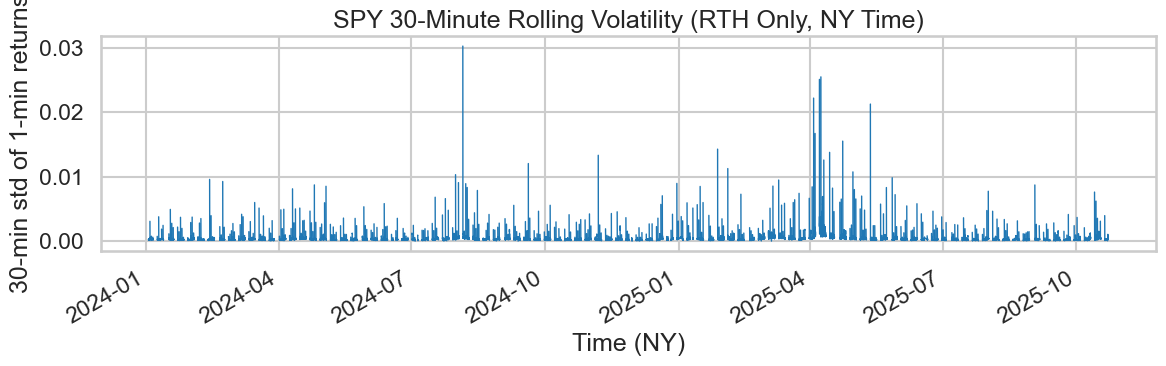

In [32]:
# Ensure datetime index
df = clean.set_index("timestamp_ny").sort_index()

# Compute 30-min rolling volatility (of 1-min returns)
df["vol_30m"] = df["ret"].rolling("30min").std()

plt.figure(figsize=(12,4))
df["vol_30m"].plot(color="tab:blue", lw=1.0)
plt.title("SPY 30-Minute Rolling Volatility (RTH Only, NY Time)")
plt.xlabel("Time (NY)")
plt.ylabel("30-min std of 1-min returns")
plt.tight_layout()
plt.show()


Volume

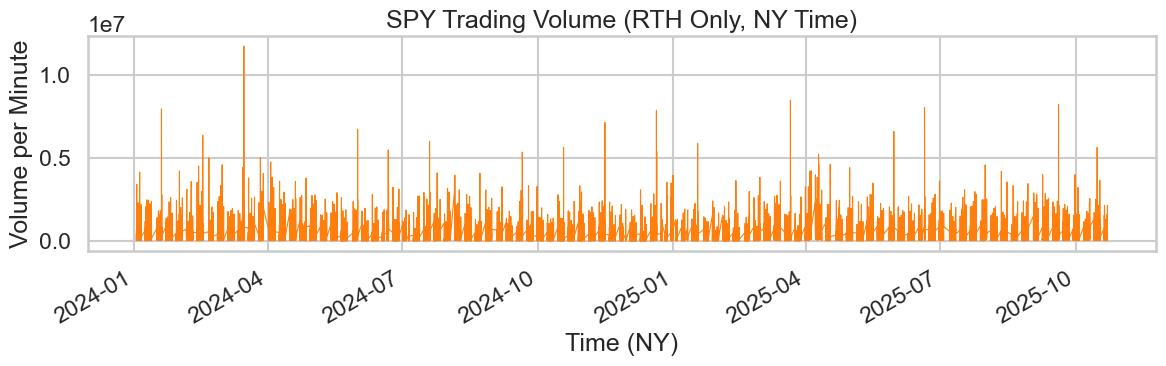

In [33]:
plt.figure(figsize=(12,4))
clean.set_index("timestamp_ny")["volume"].plot(color="tab:orange", lw=0.8)
plt.title("SPY Trading Volume (RTH Only, NY Time)")
plt.xlabel("Time (NY)")
plt.ylabel("Volume per Minute")
plt.tight_layout()
plt.show()


Intraday Volume Pattern

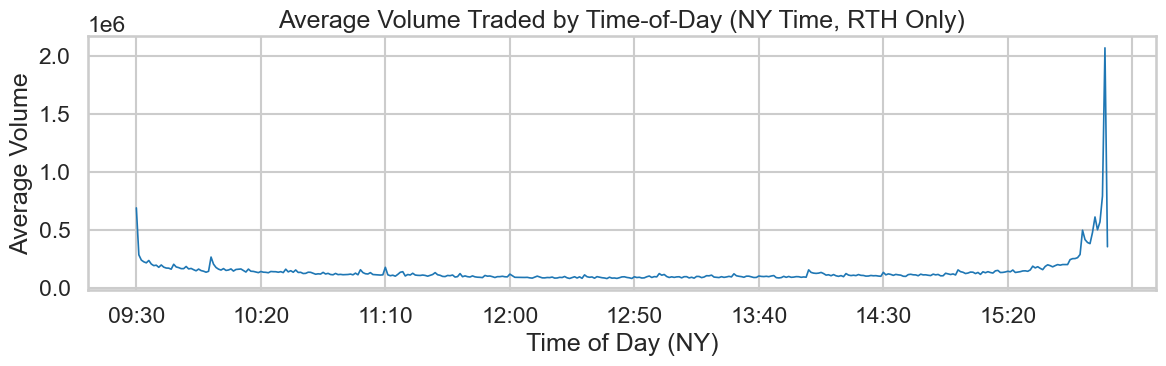

In [35]:
# Work on the cleaned RTH dataset (already in NY time)
df = clean.set_index("timestamp_ny").sort_index()

# Compute mean volume for each minute of the trading day (DST-safe)
intraday_vol = (
    df.groupby([df.index.hour, df.index.minute])["volume"]
      .mean()
)

# Format the index as HH:MM NY time
intraday_vol.index = [f"{h:02d}:{m:02d}" for (h, m) in intraday_vol.index]

# Plot
plt.figure(figsize=(12,4))
intraday_vol.plot(color="tab:blue", lw=1.2)
plt.title("Average Volume Traded by Time-of-Day (NY Time, RTH Only)")
plt.xlabel("Time of Day (NY)")
plt.ylabel("Average Volume")
plt.tight_layout()
plt.show()


Volume-Volatility

In [41]:
# Use the cleaned RTH dataset
df = clean.copy()

# Compute absolute returns if not already present
if "ret" not in df.columns:
    df["ret"] = df["close"].pct_change()

df["abs_ret"] = df["ret"].abs()

# Correlation between volume and absolute return (volatility proxy)
corr = df[["abs_ret", "volume"]].corr().loc["volume", "abs_ret"]
print(f"Correlation between absolute return and volume (RTH only): {corr:.3f}")


Correlation between absolute return and volume (RTH only): 0.298


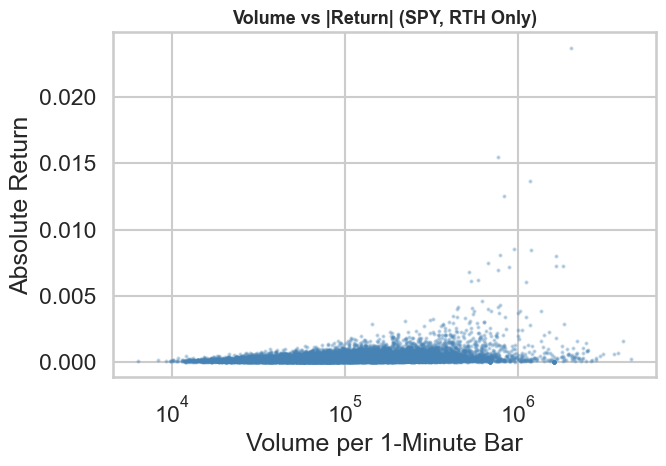

In [42]:
# Work on the cleaned RTH dataset
df = clean.copy()

# Ensure returns and absolute returns exist
if "ret" not in df.columns:
    df["ret"] = df["close"].pct_change()
df["abs_ret"] = df["ret"].abs()

# Take a random sample for plotting (avoid overplotting)
sample = df.sample(min(20000, len(df)), random_state=0)

plt.figure(figsize=(7,5))
plt.scatter(sample["volume"], sample["abs_ret"], s=2, alpha=0.3, color="steelblue")
plt.title("Volume vs |Return| (SPY, RTH Only)", fontsize=13, weight="bold")
plt.xlabel("Volume per 1-Minute Bar")
plt.ylabel("Absolute Return")
plt.xscale("log")  # log-scale volume clarifies the pattern
plt.tight_layout()
plt.show()

## Descriptive Statistics

mean, std, skew, kurtosis, rolling vol, etc.

In [43]:
# Use the cleaned RTH dataset
df = clean.copy()

# Ensure returns exist
if "ret" not in df.columns:
    df["ret"] = df["close"].pct_change()

# Drop NaN (from first bar of each day)
ret = df["ret"].dropna()

print("=== 1-Minute Return Statistics (RTH Only) ===")
print(ret.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
print(f"\nMean (per interval):  {ret.mean():.6f}")
print(f"Std  (per interval):   {ret.std():.6f}")
print(f"Skew:                  {ret.skew():.3f}")
print(f"Kurtosis:              {ret.kurtosis():.3f}")


=== 1-Minute Return Statistics (RTH Only) ===
count    1.771240e+05
mean     2.088117e-06
std      5.106521e-04
min     -4.108792e-02
1%      -1.106705e-03
5%      -5.439117e-04
50%      1.839504e-07
95%      5.209762e-04
99%      1.068051e-03
max      3.326074e-02
Name: ret, dtype: float64

Mean (per interval):  0.000002
Std  (per interval):   0.000511
Skew:                  -2.759
Kurtosis:              834.378


### visual checks

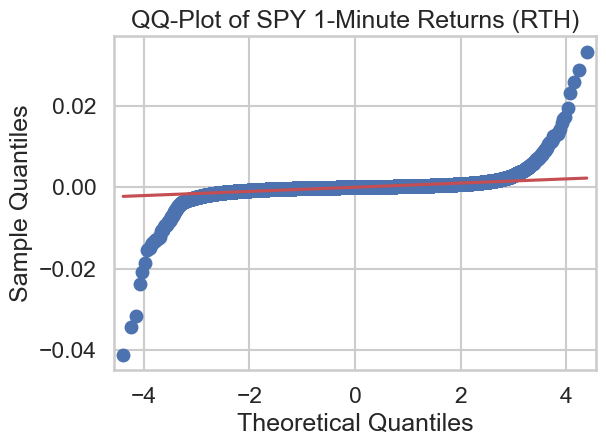

In [46]:
sm.qqplot(ret, line='s')
plt.title("QQ-Plot of SPY 1-Minute Returns (RTH)")
plt.tight_layout()
plt.show()

## Inferential checks
correlations, t-tests, OLS regressions (e.g. return ~ sentiment)

### Correlation Matrix 
- postiive correlation between volume and bas_ret 
- ret vs volume correlation should hover around zero  ( price direction not linearly related to volume )
- vol_5m vs vol_30m -> strong correlation (vol clustering)

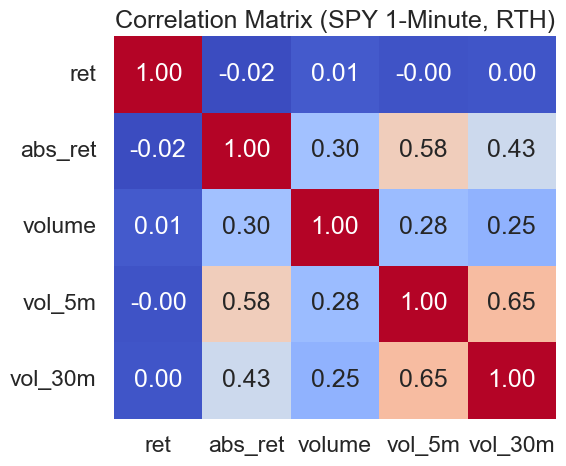

In [48]:
# correlation matrix
# Ensure features exist
df = clean.copy()
df["abs_ret"] = df["ret"].abs()

# Select variables of interest
corr_vars = ["ret", "abs_ret", "volume", "vol_5m", "vol_30m"]
corr_matrix = df[corr_vars].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Correlation Matrix (SPY 1-Minute, RTH)")
plt.tight_layout()
plt.show()

### t-tests - autocorrelation & mean-reversion
- t-tests: p>0.05 -> means return is statitsically indistinguishable from zero 
- Ljung-Box: p < 0.05 -> autocorrelation exists -> intraday returns are not entirely independent, showing microstructure effects (momentum or reversal)

In [51]:
# 1. Test if mean return differs from 0
t_stat, p_val = stats.ttest_1samp(df["ret"].dropna(), 0)
print(f"T-test mean=0 → t={t_stat:.2f}, p={p_val:.4f}")

# 2. Ljung–Box test for autocorrelation (lags 5, 10, 20)
print("\nLjung–Box test p-values:")
print(acorr_ljungbox(df["ret"].dropna(), lags=[5, 10, 20], return_df=True))

T-test mean=0 → t=1.72, p=0.0853

Ljung–Box test p-values:
       lb_stat     lb_pvalue
5    14.990618  1.040250e-02
10  155.090109  3.336600e-28
20  238.498738  2.359193e-39


### OLS regression - Return vs Volume, Volatility
- R^2 is very low (< 0.01): intraday direction is extremely noisy
- Coefficients:
    - log_volume: usually insignificant for direction (return), but positive for abs_ret 
    - vol_5m / vol_30m: might carry weak negative coefficients (short-term reversal)

In [52]:
# Drop NaN rows for regression
reg_df = df.dropna(subset=["ret", "volume", "vol_5m", "vol_30m"]).copy()

# Take log(volume) since it's skewed
reg_df["log_volume"] = np.log1p(reg_df["volume"])

# OLS: Return ~ log(Volume) + vol_5m + vol_30m
X = reg_df[["log_volume", "vol_5m", "vol_30m"]]
X = sm.add_constant(X)
y = reg_df["ret"]

ols = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})  # robust SEs
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                   0.09431
Date:                Sat, 08 Nov 2025   Prob (F-statistic):              0.963
Time:                        23:13:41   Log-Likelihood:             1.0912e+06
No. Observations:              177124   AIC:                        -2.182e+06
Df Residuals:                  177120   BIC:                        -2.182e+06
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.484e-06   3.81e-05     -0.065      0.9

In [53]:
# OLS for volatility modelliing
y = reg_df["abs_ret"]
X = reg_df[["log_volume", "vol_5m", "vol_30m"]]
X = sm.add_constant(X)
ols_vol = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(ols_vol.summary())

                            OLS Regression Results                            
Dep. Variable:                abs_ret   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     2943.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:21:07   Log-Likelihood:             1.1542e+06
No. Observations:              177124   AIC:                        -2.308e+06
Df Residuals:                  177120   BIC:                        -2.308e+06
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007   3.13e-05    -22.782      0.0

## Stationarity tests

## Lag significance tests

## Normality and Distribution Checks

### visual checks - histogram + KDE

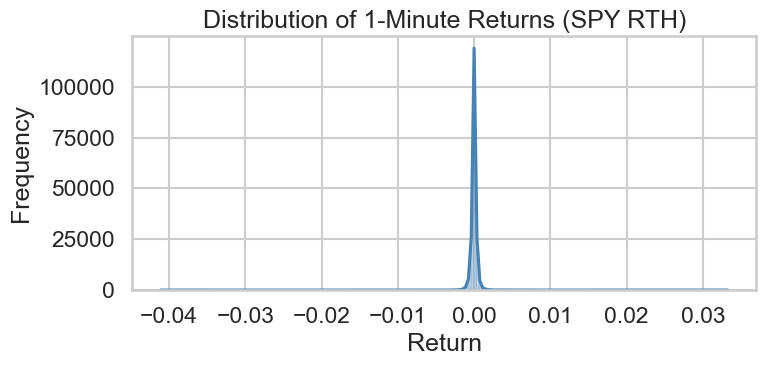

In [54]:
df = clean.copy()
ret = df["ret"].dropna()

plt.figure(figsize=(8,4))
sns.histplot(ret, bins=200, kde=True, color="steelblue")
plt.title("Distribution of 1-Minute Returns (SPY RTH)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [57]:
print("=== Normality Tests ===")
jb_stat, jb_p = stats.jarque_bera(ret)
sw_stat, sw_p = stats.shapiro(ret.sample(5000, random_state=0))   # Shapiro max n≈5000
dag_stat, dag_p = stats.normaltest(ret)

print(f"Jarque-Bera:    stat={jb_stat:.2f},  p={jb_p:.3e}")
print(f"Shapiro-Wilk:   stat={sw_stat:.2f},  p={sw_p:.3e}")
print(f"D’Agostino K²:  stat={dag_stat:.2f}, p={dag_p:.3e}")


=== Normality Tests ===
Jarque-Bera:    stat=5137913742.46,  p=0.000e+00
Shapiro-Wilk:   stat=0.59,  p=5.160e-76
D’Agostino K²:  stat=165595.03, p=0.000e+00


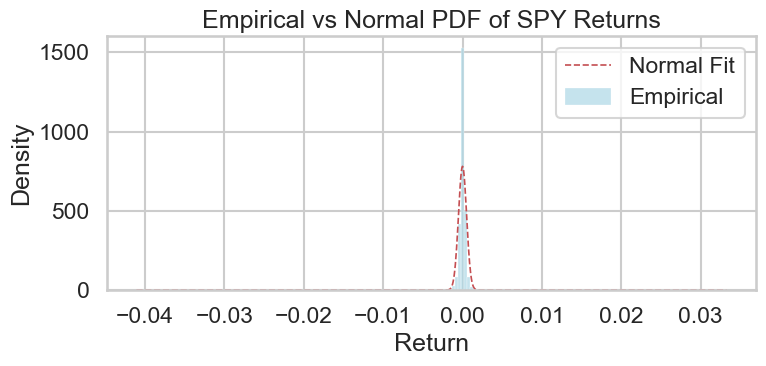

In [60]:
from scipy.stats import norm
import numpy as np

mu, sigma = ret.mean(), ret.std()

plt.figure(figsize=(8,4))
sns.histplot(ret, bins=200, stat='density', color='lightblue', label='Empirical', alpha=0.7)
x = np.linspace(ret.min(), ret.max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=1.2, label='Normal Fit')
plt.title("Empirical vs Normal PDF of SPY Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


Normality tests and Q-Q plots confirm that 1-minte SPY returns deviate from the Gaussian assumptiopn. 
- The empirical distribution exhibits excess kurtosis and slight negative skewness,
- This means that large intraday price movements occur more frequently than predicted by a normal model
- Thse findings support the use of non-linear models (e.g., CNN-LSTM) capable of capturing tail risk, volatility clustering, and asymmetric behaviours that traditional linear models can't 

# Backtest

In [ ]:
# Convert daily Markov regime probabilities into a pseudo intraday prob_up signal
# (assume high-vol regime = bearish, low-vol regime = bullish)

# Rescale: low-vol (0) → prob_up ≈ 0.6, high-vol (1) → prob_up ≈ 0.4
SPY_daily["prob_up"] = 0.6 - 0.2 * p_hi.values  # linear inverse mapping

# Merge back to 1-min RTH data (clean)
df_bt = clean.copy()
df_bt = df_bt.merge(
    SPY_daily[["prob_up"]],
    left_on=df_bt["timestamp_ny"].dt.floor("D"),
    right_index=True,
    how="left"
)

# Drop NaNs and shift one bar forward for execution lag
df_bt["prob_up"] = df_bt["prob_up"].shift(1)
df_bt = df_bt.dropna(subset=["prob_up"])

# Run backtest
from backtest import backtest_minute_open_to_open
bt_res = backtest_minute_open_to_open(
    df=df_bt,
    prob_col="prob_up",
    upper=0.55, lower=0.45,
    hold_bars=5,
    cost_bps_per_side=0.0,
    slippage_bps_per_side=0.0
)

perf, trades, metrics = bt_res["df_perf"], bt_res["trades"], bt_res["metrics"]


trades["ret_pct"].describe()
trades["direction"].value_counts(normalize=True)
print(metrics)

{'bars': 176762, 'exposure': 0.7635973795272739, 'ann_return_geom': 0.5236013302679012, 'sharpe': 2.088124797542861, 'ann_vol': 0.1394185402938724, 'max_drawdown': -0.10656902864394491, 'hit_rate': 0.5160406016151737, 'avg_trade_ret': 2.002975553571299e-05, 'median_trade_ret': 2.43163032047633e-05, 'avg_holding_bars': 26.87549084981848, 'trades': 26994}


# Export Data